# Patent Reduction

## Purpose

The purpose of this program is to identify the core similiarities between 42 patents and applications, and reduce their number to the top 3 or 4 based on ngrams and other factors.

## Work Plan

- Get full text of patents
- Analyze ngrams of pantents
- Identify embeddings 
- Conduct dimension reduction technique

In [50]:
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re

In [51]:
patent_folder ='./Patents/gp-search-20170622-225739.csv'

In [52]:
df = pd.read_csv(patent_folder, skiprows=1)

In [53]:
df.head()

,id,title,assignee,inventor/author,priority date,filing/creation date,publication date,grant date,result link
0,US7286245B2,Method and apparatus for determining the influ...,Carl Zeiss Smt Ag,"Ulrich Wegmann, Michael Hartl, Markus Mengel, ...",2002-07-29,2003-07-29,2007-10-23,2007-10-23,https://patents.google.com/patent/US7286245B2/en
1,US20080043236A1,Optical Property Measurement Apparatus and Opt...,Nikon Corporation,"Koji Kaise, Toru Fujii, Yasushi Mizuno",2004-08-09,2005-08-09,2008-02-21,NaN,https://patents.google.com/patent/US2008004323...
2,US7277182B2,Apparatus for polarization-specific examinatio...,Carl Zeiss Smt Ag,"Ulrich Wegmann, Markus Mengel",2003-07-05,2004-07-06,2007-10-02,2007-10-02,https://patents.google.com/patent/US7277182B2/en
3,US6788389B2,Production method of projection optical system,Nikon Corporation,"Youhei Fujishima, Hironori Ikezawa, Toshihiko ...",2001-07-10,2002-07-10,2004-09-07,2004-09-07,https://patents.google.com/patent/US6788389B2/en
4,US6870668B2,Method for evaluating image formation performa...,Nikon Corporation,Toshihiko Ozawa,2000-10-10,2001-10-09,2005-03-22,2005-03-22,https://patents.google.com/patent/US6870668B2/en


In order to download the text of each of the patents listed above, we'll use the unique urls for each patent provided by the United States Patent and Trademark Office and then scrape the pages using BeautifulSoup. 

## Generating the Unique URLs

Select the "id" column in the data frame. 

In [54]:
patent_id_column=df['id']

Next, create a list that contains each id number

In [55]:
patent_id = [i for i in patent_id_column]

An inspection of the USPTO website reveals that the url for each patent contains the patent number repeated three times within the url. However, the initial 'US' and final 'A1' or 'B2' has been removed. 

To to that end, we need to slice each item in the patent_id list so as to remove the intial two and final two charachers from each item.   

In [56]:
patent_id_numbers =[i[2:-2] for i in patent_id_column]

For example:

In [57]:
patent_id[0] 

'US7286245B2'

versus

In [58]:
patent_id_numbers[0]

'7286245'

Next, we take the patent_id_numbers and insert them into the url template so as to create the unique url for each patent.

To do that, we'll use a for loop where we replace each instance of the patent number with 'i'.

In [59]:
url_list = []
for i in patent_id_numbers:
    #Use each of the unique patent id numbers to create a unique url
    url = "http://patft.uspto.gov/netacgi/nph-Parser?Sect1=PTO1&Sect2=HITOFF&d=PALL&p=1&u=%2Fnetahtml%2FPTO%2Fsrchnum.htm&r=1&f=G&l=50&s1="+i+".PN.&OS=PN/"+i+"&RS=PN/"+i
    url_list.append(url)
    

Now we have a list of the unique urls for each of the patents. 

Next, in order to analyze the text, we need to to get the text from patent's webpage. To do so, we use BeautifulSoup.  

In [60]:

#count = 0
#for url in url_list:
    #opens each of the patent urls, scrapes the page
#    page = urlopen(url)
#   soup = BeautifulSoup(page, 'lxml')
#  count += 1
    #opens and writes a text document with the text for each patent. 
    #each file is named 'patent' and its corresponding number
#    with open('patent{}.txt'.format(count), 'w') as f:
#        f.write(soup.decode('utf8'))
###    

To problems:
1) I keep getting a "ERRNO 104: Connection Error" which requires me to run the above cell several times. 
2) Unfortuanately, some the urls are not actually the patents we're looking for :) To that end, I'm switching back to the Google urls.

## Using Google

The loop below creates a list of urls for each of the patents.

In [61]:
stem = 'https://patents.google.com/patent/'
google_url_list=[]
for patent in patent_id:
    google_url = stem+patent
    google_url_list.append(google_url)

Next, we loop through each of the urls, scrape the title and abstract from each url, and then write it to a text file.

The files are titled "patent" and the number of the file. The goal is to replace this working title with the actual title of the patents.

In [62]:
count = 0
for url in google_url_list:
    page = urlopen(url)
    soup = BeautifulSoup(page, 'lxml')
    count += 1
    with open('patent{}.txt'.format(count), 'w') as f:
        f.write(soup.title.text[:-25]) #Removes '        - Google Patents' from the end of the title 
        f.write(soup.abstract.text)

In [63]:
import spacy
from collections import Counter, defaultdict
nlp = spacy.load('en')

In [64]:
docs = []
import os
for filename in os.listdir(os.getcwd()):
    if filename.endswith('.txt'):
        docs.append(nlp(open(filename).read()))

In [65]:
# Get first token of the processed document
doc = docs[0]

# Print sentences (one sentence per line)
for sent in doc.sents:
    print(sent)

US7298498B2 - Optical property measuring apparatus and optical property measuring method, exposure apparatus and exposure method, and device manufacturing method 

By an insertion/withdrawal mechanism, a wavefront division optical element is inserted to an optical path of a light via an optical system to be examined, or the inserted wavefront division optical element is withdrawn from the optical path.
Thus, it becomes possible without using a half mirror to make the light via the optical system to be examined be received at a detector via the wavefront division optical element, or the light via the optical system to be examined be received at the detector without the wavefront division optical element.
Therefore, the measurement precision of optical properties obtained based on a detection signal from the detector cannot be deteriorated due to a polarization property existing in the half mirror.
Accordingly, optical properties of the optical system to be examined can be detected with 

In [66]:
#article = read_file('data/article.txt')

keywords = Counter()
for chunk in doc.noun_chunks:
    if nlp.vocab[chunk.lemma_].prob < - 8: # probablity value -8 is arbitrarily selected threshold
        keywords[chunk.lemma_] += 1

keywords.most_common(20)


[('the optical system', 3),
 ('the light', 2),
 ('the wavefront division optical element', 2),
 ('the detector', 2),
 ('optical property', 2),
 ('an insertion/withdrawal mechanism', 1),
 ('a wavefront division optical element', 1),
 ('an optical path', 1),
 ('a light', 1),
 ('an optical system', 1),
 ('the insert wavefront division optical element', 1),
 ('the optical path', 1),
 ('a half mirror', 1),
 ('a detector', 1),
 ('the measurement precision', 1),
 ('a detection signal', 1),
 ('a polarization property', 1),
 ('the half mirror', 1),
 ('high precision', 1)]

In [67]:
cross_similarity_matrix = []

for doc1 in docs:
    cross_similarity_vector = []
    for doc2 in docs:
        cross_similarity_vector.append(doc1.similarity(doc2))
    cross_similarity_matrix.append(cross_similarity_vector)

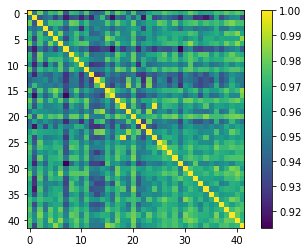

In [68]:
import matplotlib.pyplot as plt
plt.imshow(cross_similarity_matrix, aspect=1)
plt.colorbar()
plt.show()

In [69]:
from sklearn.manifold import TSNE
import numpy as np
# seems very sensitive to random_state , algorith unstable at this time
model = TSNE(n_components=3, random_state=42)
np.set_printoptions(suppress=True)

# doc.vector returns average vector of all tokens, not a good metric, but should work for first try
X = []
for doc in docs:
    X.append(doc.vector)
mapped = model.fit_transform( X ) 

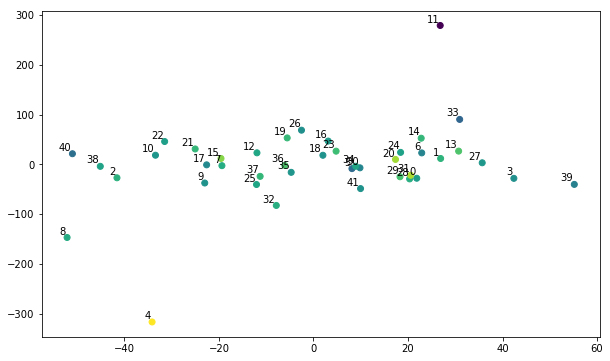

In [70]:
plt.figure(figsize=(10,6))
plt.scatter(mapped[:,0],mapped[:,1], c = mapped[:,2])

for label, x, y in zip(df.index, mapped[:,0],mapped[:,1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-1, 1),
        textcoords='offset points', ha='right', va='bottom',
      #  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
      #  arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
        )

plt.show()